In [1]:
!pip install -q openmeteo-requests
!pip install -q requests-cache retry-requests numpy pandas

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.1 which is incompatible.


In [2]:
import pickle
import warnings
warnings.filterwarnings('ignore')

In [35]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 11.9338,
	"longitude": 79.8298,
	"start_date": "1940-01-01",
	"end_date": "2024-05-24",
	"daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunshine_duration", "precipitation_sum", "rain_sum", "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant", "shortwave_radiation_sum", "et0_fao_evapotranspiration"]
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(7).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(8).ValuesAsNumpy()
daily_rain_sum = daily.Variables(9).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(10).ValuesAsNumpy()
daily_wind_speed_10m_max = daily.Variables(11).ValuesAsNumpy()
daily_wind_gusts_10m_max = daily.Variables(12).ValuesAsNumpy()
daily_wind_direction_10m_dominant = daily.Variables(13).ValuesAsNumpy()
daily_shortwave_radiation_sum = daily.Variables(14).ValuesAsNumpy()
daily_et0_fao_evapotranspiration = daily.Variables(15).ValuesAsNumpy()

# Ensure the date values are correctly formatted as datetime objects
dates = pd.date_range(
    start=pd.to_datetime(daily.Time(), unit="s", utc=True),
    end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
    freq=pd.Timedelta(seconds=daily.Interval()),
    inclusive="left"
).tz_convert(None)  # Remove timezone information for consistency

# Create a dictionary for the data
daily_data = {
    "date": dates,
    "weather_code": daily_weather_code,
    "tmax": daily_temperature_2m_max,
    "tmin": daily_temperature_2m_min,
    "tmean": daily_temperature_2m_mean,
    "atmax": daily_apparent_temperature_max,
    "atmin": daily_apparent_temperature_min,
    "atmean": daily_apparent_temperature_mean,
    "sun_dur": daily_sunshine_duration,
    "prec_sum": daily_precipitation_sum,
    "prec_hrs": daily_precipitation_hours,
    "wsmax": daily_wind_speed_10m_max,
    "wgmax": daily_wind_gusts_10m_max,
    "wdirdom": daily_wind_direction_10m_dominant,
    "radsum": daily_shortwave_radiation_sum,
    "evapotrans": daily_et0_fao_evapotranspiration
}

# Create the DataFrame and set the date as the index
df = pd.DataFrame(data=daily_data)
df.set_index("date", inplace=True)

# Display the DataFrame
df

Coordinates 11.915641784667969°N 79.82959747314453°E
Elevation 8.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,weather_code,tmax,tmin,tmean,atmax,atmin,atmean,sun_dur,prec_sum,prec_hrs,wsmax,wgmax,wdirdom,radsum,evapotrans
date,,,,,,,,,,,,,,,
1940-01-01,51.0,26.504000,21.903999,23.983168,26.505602,23.250010,24.493334,NaN,NaN,1.0,26.649727,NaN,36.791718,NaN,NaN
1940-01-02,51.0,26.604000,21.804001,24.072754,26.657646,22.715544,24.850416,37593.488281,0.100000,1.0,20.774214,36.360001,39.377998,15.240000,3.851080
1940-01-03,51.0,26.704000,21.454000,23.799833,26.970911,22.288740,24.420395,38098.847656,0.800000,7.0,23.424908,37.079998,33.854286,16.190001,3.848363
1940-01-04,51.0,26.403999,21.254000,23.660250,26.507622,22.575235,24.615953,37838.628906,1.300000,11.0,21.794127,36.360001,36.232147,15.750000,3.588235
1940-01-05,51.0,25.704000,21.254000,23.643585,26.650599,22.522390,24.378830,37959.140625,0.800000,7.0,22.932877,37.439999,31.960617,16.110001,3.714891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,63.0,29.693501,25.543499,27.233084,36.991371,30.805893,33.047207,7003.973633,16.600002,11.0,11.480557,30.960001,292.094269,10.530000,2.332764
2024-05-21,65.0,30.493500,25.743500,27.478914,36.885780,31.237324,33.698616,15235.697266,24.499998,15.0,11.304229,24.480000,330.847778,12.140000,2.613702
2024-05-22,65.0,30.393499,26.043499,27.626833,36.616554,31.574471,33.510700,18297.066406,19.400002,14.0,14.869351,28.080000,330.736237,11.760000,2.572521


In [4]:
df.to_csv('/kaggle/working/py_weather_data.csv')

In [36]:
df.isna().sum()/df.shape[0]

weather_code    0.000000
tmax            0.000000
tmin            0.000000
tmean           0.000000
atmax           0.000000
atmin           0.000000
atmean          0.000000
sun_dur         0.000032
prec_sum        0.000032
prec_hrs        0.000000
wsmax           0.000000
wgmax           0.000032
wdirdom         0.000000
radsum          0.000032
evapotrans      0.000032
dtype: float64

In [37]:
df.isna().sum()

weather_code    0
tmax            0
tmin            0
tmean           0
atmax           0
atmin           0
atmean          0
sun_dur         1
prec_sum        1
prec_hrs        0
wsmax           0
wgmax           1
wdirdom         0
radsum          1
evapotrans      1
dtype: int64

In [38]:
df=df.bfill()
df=df.ffill()

In [39]:
df.isna().sum()

weather_code    0
tmax            0
tmin            0
tmean           0
atmax           0
atmin           0
atmean          0
sun_dur         0
prec_sum        0
prec_hrs        0
wsmax           0
wgmax           0
wdirdom         0
radsum          0
evapotrans      0
dtype: int64

In [8]:
df.corr()

,weather_code,tmax,tmin,tmean,atmax,atmin,atmean,sun_dur,prec_sum,prec_hrs,wsmax,wgmax,wdirdom,radsum,evapotrans
weather_code,1.000000,-0.054600,0.129788,0.001838,0.045080,0.214242,0.136851,-0.279812,0.383357,0.644730,-0.085466,-0.013893,0.086106,-0.381596,-0.397929
tmax,-0.054600,1.000000,0.862931,0.968882,0.918348,0.781019,0.887390,0.255019,-0.272900,-0.404904,0.226076,0.288074,0.656762,0.502061,0.794681
tmin,0.129788,0.862931,1.000000,0.944711,0.836200,0.914476,0.899180,0.066239,-0.100100,-0.158690,0.281368,0.297450,0.612592,0.250978,0.568900
tmean,0.001838,0.968882,0.944711,1.000000,0.914411,0.867050,0.931586,0.193655,-0.223578,-0.333774,0.253845,0.298766,0.657401,0.425641,0.737621
atmax,0.045080,0.918348,0.836200,0.914411,1.000000,0.865832,0.963495,0.305287,-0.191023,-0.288820,0.041027,0.098535,0.650963,0.565574,0.690290
atmin,0.214242,0.781019,0.914476,0.867050,0.865832,1.000000,0.950387,0.122262,-0.077878,-0.077037,0.094660,0.140148,0.575775,0.318961,0.456763
atmean,0.136851,0.887390,0.899180,0.931586,0.963495,0.950387,1.000000,0.199329,-0.136652,-0.187365,0.045914,0.114115,0.645793,0.435705,0.582862
sun_dur,-0.279812,0.255019,0.066239,0.193655,0.305287,0.122262,0.199329,1.000000,-0.522094,-0.485408,-0.013542,-0.034995,-0.011903,0.827289,0.613492
prec_sum,0.383357,-0.272900,-0.100100,-0.223578,-0.191023,-0.077878,-0.136652,-0.522094,1.000000,0.666306,0.022688,0.051282,-0.058249,-0.511272,-0.511046
prec_hrs,0.644730,-0.404904,-0.158690,-0.333774,-0.288820,-0.077037,-0.187365,-0.485408,0.666306,1.000000,-0.101726,-0.066274,-0.181073,-0.625899,-0.696691


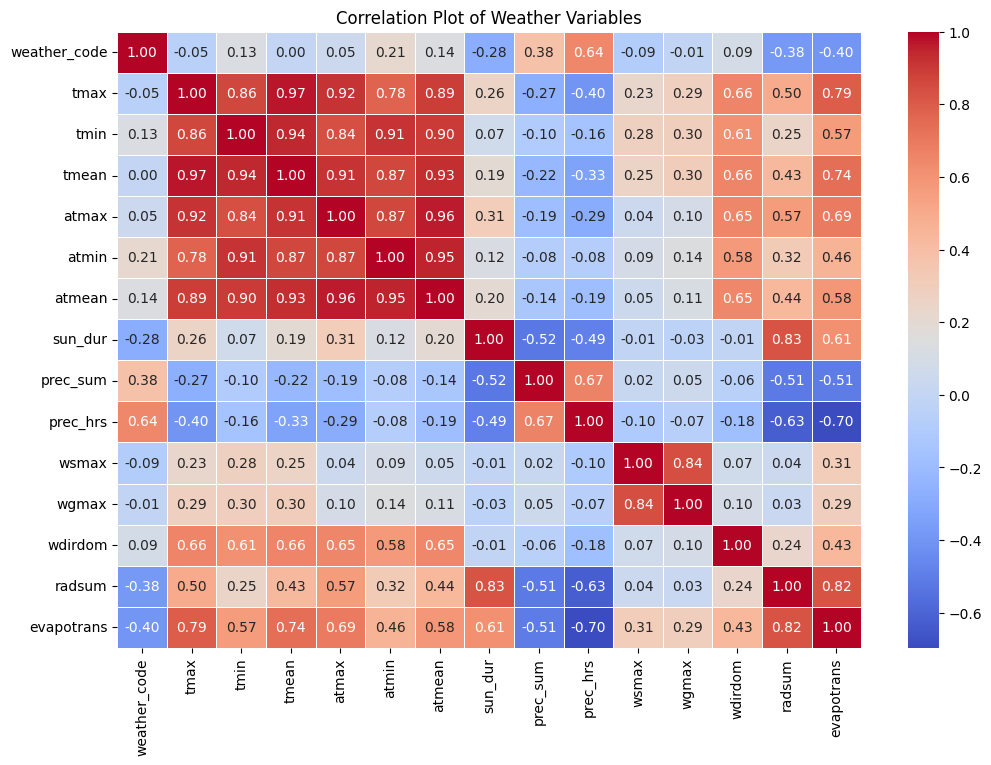

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot of Weather Variables')
plt.show()


In [10]:
df.weather_code.value_counts()

weather_code
51.0    8505
2.0     5554
1.0     4420
53.0    3213
61.0    2699
3.0     2485
63.0    1995
55.0    1113
0.0      676
65.0     166
Name: count, dtype: int64

In [11]:
import plotly.graph_objs as go

# Create a Plotly figure
fig = go.Figure()

# Add a line trace for weather_code over time
fig.add_trace(go.Scatter(x=df.index, y=df['weather_code'], mode='lines+markers', name='Weather Code'))

# Update layout
fig.update_layout(
    title='Weather Code Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Weather Code'),
    hovermode='x unified'
)

# Show the plot
fig.show()


In [40]:
# Weather descriptions dictionary
weather_descriptions = {
    0: "Sunny",
    1: "Mainly Sunny",
    2: "Partly Cloudy",
    3: "Cloudy",
    45: "Foggy",
    48: "Rime Fog",
    51: "Clear",
    53: "Drizzle",
    55: "Heavy Drizzle",
    56: "Light Freezing Drizzle",
    57: "Freezing Drizzle",
    61: "Light Rain",
    63: "Rain",
    65: "Heavy Rain",
    66: "Light Freezing Rain",
    67: "Freezing Rain",
    71: "Light Snow",
    73: "Snow",
    75: "Heavy Snow",
    77: "Snow Grains",
    80: "Light Showers",
    81: "Showers",
    82: "Heavy Showers",
    85: "Light Snow Showers",
    86: "Snow Showers",
    95: "Thunderstorm",
    96: "Light Thunderstorms With Hail",
    99: "Thunderstorm With Hail"
}

# Replace weather codes with descriptions
df_new = df.copy()
df_new['weather_code'] = df_new['weather_code'].map(weather_descriptions)


# Display the updated DataFrame
df_new


,weather_code,tmax,tmin,tmean,atmax,atmin,atmean,sun_dur,prec_sum,prec_hrs,wsmax,wgmax,wdirdom,radsum,evapotrans
date,,,,,,,,,,,,,,,
1940-01-01,Clear,26.504000,21.903999,23.983168,26.505602,23.250010,24.493334,37593.488281,0.100000,1.0,26.649727,36.360001,36.791718,15.240000,3.851080
1940-01-02,Clear,26.604000,21.804001,24.072754,26.657646,22.715544,24.850416,37593.488281,0.100000,1.0,20.774214,36.360001,39.377998,15.240000,3.851080
1940-01-03,Clear,26.704000,21.454000,23.799833,26.970911,22.288740,24.420395,38098.847656,0.800000,7.0,23.424908,37.079998,33.854286,16.190001,3.848363
1940-01-04,Clear,26.403999,21.254000,23.660250,26.507622,22.575235,24.615953,37838.628906,1.300000,11.0,21.794127,36.360001,36.232147,15.750000,3.588235
1940-01-05,Clear,25.704000,21.254000,23.643585,26.650599,22.522390,24.378830,37959.140625,0.800000,7.0,22.932877,37.439999,31.960617,16.110001,3.714891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,Rain,29.693501,25.543499,27.233084,36.991371,30.805893,33.047207,7003.973633,16.600002,11.0,11.480557,30.960001,292.094269,10.530000,2.332764
2024-05-21,Heavy Rain,30.493500,25.743500,27.478914,36.885780,31.237324,33.698616,15235.697266,24.499998,15.0,11.304229,24.480000,330.847778,12.140000,2.613702
2024-05-22,Heavy Rain,30.393499,26.043499,27.626833,36.616554,31.574471,33.510700,18297.066406,19.400002,14.0,14.869351,28.080000,330.736237,11.760000,2.572521


In [41]:
df_new.weather_code.value_counts()

weather_code
Clear            8505
Partly Cloudy    5554
Mainly Sunny     4420
Drizzle          3213
Light Rain       2699
Cloudy           2485
Rain             1995
Heavy Drizzle    1113
Sunny             676
Heavy Rain        166
Name: count, dtype: int64

In [15]:
df_new[df_new.weather_code=="Clear"]

,weather_code,tmax,tmin,tmean,atmax,atmin,atmean,sun_dur,prec_sum,prec_hrs,wsmax,wgmax,wdirdom,radsum,evapotrans
date,,,,,,,,,,,,,,,
1940-01-01,Clear,26.504000,21.903999,23.983168,26.505602,23.250010,24.493334,37593.488281,0.1,1.0,26.649727,36.360001,36.791718,15.240000,3.851080
1940-01-02,Clear,26.604000,21.804001,24.072754,26.657646,22.715544,24.850416,37593.488281,0.1,1.0,20.774214,36.360001,39.377998,15.240000,3.851080
1940-01-03,Clear,26.704000,21.454000,23.799833,26.970911,22.288740,24.420395,38098.847656,0.8,7.0,23.424908,37.079998,33.854286,16.190001,3.848363
1940-01-04,Clear,26.403999,21.254000,23.660250,26.507622,22.575235,24.615953,37838.628906,1.3,11.0,21.794127,36.360001,36.232147,15.750000,3.588235
1940-01-05,Clear,25.704000,21.254000,23.643585,26.650599,22.522390,24.378830,37959.140625,0.8,7.0,22.932877,37.439999,31.960617,16.110001,3.714891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-21,Clear,33.593498,27.193501,30.458078,39.684475,33.468838,36.223633,40132.734375,0.5,4.0,23.708124,46.799999,153.966919,24.809999,5.608640
2024-04-25,Clear,33.693501,26.743500,30.283081,39.487003,33.288261,36.161503,40948.906250,0.2,2.0,21.897945,44.639996,146.752289,24.639999,5.603846
2024-04-26,Clear,33.543499,26.293499,30.062250,39.233788,32.264194,35.791935,40951.089844,0.1,1.0,20.124611,41.760002,144.613937,24.360001,5.570168


In [16]:
# Extract month and year from the 'date' column
df_new['year'] = df_new.index.year
df_new['month'] = df_new.index.month

# Define a list of weather descriptions that indicate rain
rain_descriptions = ["Light Drizzle", "Drizzle", "Heavy Drizzle", "Light Rain", "Rain", "Heavy Rain"]

# Filter the DataFrame for rows where the weather description indicates rain
rain_df = df_new[df_new['weather_code'].isin(rain_descriptions)]

# Group by year and month to see which months had rain
rain_months = rain_df.groupby(['month']).size().reset_index(name='days_with_rain').sort_values(by='days_with_rain',ascending=False)

# Display the months with rain
rain_months.head(24)

,month,days_with_rain
9,10,1601
8,9,1253
10,11,1246
7,8,1098
6,7,986
5,6,761
11,12,686
4,5,627
3,4,351
0,1,230


In [36]:
import plotly.express as px

# Group by year and month
rain_months = rain_df.groupby(['year', 'month']).size().reset_index(name='days_with_rain')

# Create an interactive bar plot for rainy days per month
fig = px.bar(
    rain_months,
    x='month',
    y='days_with_rain',
    color='year',
    barmode='group',
    labels={'month': 'Month', 'days_with_rain': 'Days with Rain'},
    title='Monthly Rainy Days Analysis',
    template='plotly_white'
)

# Update layout for better aesthetics
fig.update_layout(
    xaxis_title='Month',
    yaxis_title='Days with Rain',
    width=1000,
    height=600,
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(1, 13)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Show plot
fig.show()


In [18]:

sun_descriptions = ["Clear","Sunny","Mainly Sunny"]

# Filter the DataFrame for rows where the weather description indicates rain
sun_df = df_new[df_new['weather_code'].isin(sun_descriptions)]

# Group by year and month to see which months had rain
sun_months = sun_df.groupby(['month']).size().reset_index(name='days_with_sun').sort_values(by='days_with_sun',ascending=False)

# Display the months with rain
sun_months.head(24)

,month,days_with_sun
4,5,1696
3,4,1551
2,3,1337
0,1,1312
1,2,1257
11,12,1130
5,6,1110
10,11,954
9,10,830
6,7,819


In [19]:
#ydc = Yearly Data Count
ydc = df.index.year.value_counts()
ydc[ydc<365]

date
2024    145
Name: count, dtype: int64

In [20]:
#leap year count
ydc[ydc>365]

date
1940    366
1956    366
1984    366
1992    366
1980    366
1996    366
1976    366
2000    366
1972    366
1968    366
2004    366
1988    366
2008    366
1960    366
2012    366
1964    366
1948    366
1952    366
2020    366
1944    366
2016    366
Name: count, dtype: int64

<Axes: xlabel='date'>

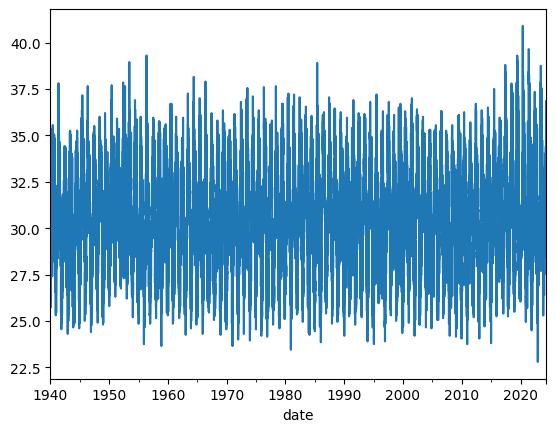

In [21]:
df_new.tmax.plot()

<Axes: xlabel='date'>

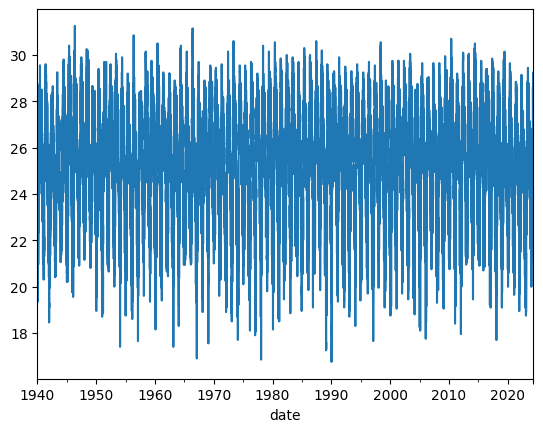

In [22]:
df_new.tmin.plot()

<Axes: xlabel='date'>

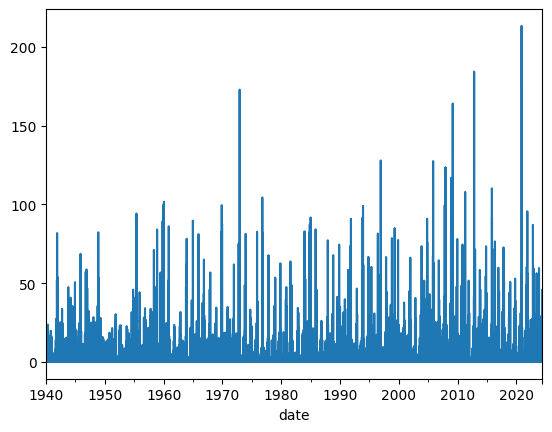

In [23]:
df_new.prec_sum.plot()

In [42]:
df_new['tar_tmax']=df_new.shift(-1)['tmax']

In [43]:
df_new

,weather_code,tmax,tmin,tmean,atmax,atmin,atmean,sun_dur,prec_sum,prec_hrs,wsmax,wgmax,wdirdom,radsum,evapotrans,tar_tmax
date,,,,,,,,,,,,,,,,
1940-01-01,Clear,26.504000,21.903999,23.983168,26.505602,23.250010,24.493334,37593.488281,0.100000,1.0,26.649727,36.360001,36.791718,15.240000,3.851080,26.604000
1940-01-02,Clear,26.604000,21.804001,24.072754,26.657646,22.715544,24.850416,37593.488281,0.100000,1.0,20.774214,36.360001,39.377998,15.240000,3.851080,26.704000
1940-01-03,Clear,26.704000,21.454000,23.799833,26.970911,22.288740,24.420395,38098.847656,0.800000,7.0,23.424908,37.079998,33.854286,16.190001,3.848363,26.403999
1940-01-04,Clear,26.403999,21.254000,23.660250,26.507622,22.575235,24.615953,37838.628906,1.300000,11.0,21.794127,36.360001,36.232147,15.750000,3.588235,25.704000
1940-01-05,Clear,25.704000,21.254000,23.643585,26.650599,22.522390,24.378830,37959.140625,0.800000,7.0,22.932877,37.439999,31.960617,16.110001,3.714891,26.854000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,Rain,29.693501,25.543499,27.233084,36.991371,30.805893,33.047207,7003.973633,16.600002,11.0,11.480557,30.960001,292.094269,10.530000,2.332764,30.493500
2024-05-21,Heavy Rain,30.493500,25.743500,27.478914,36.885780,31.237324,33.698616,15235.697266,24.499998,15.0,11.304229,24.480000,330.847778,12.140000,2.613702,30.393499
2024-05-22,Heavy Rain,30.393499,26.043499,27.626833,36.616554,31.574471,33.510700,18297.066406,19.400002,14.0,14.869351,28.080000,330.736237,11.760000,2.572521,30.543499


In [16]:
df_new.drop('weather_code',axis=1).corr()

,tmax,tmin,tmean,atmax,atmin,atmean,sun_dur,prec_sum,prec_hrs,wsmax,wgmax,wdirdom,radsum,evapotrans,tar_tmax
tmax,1.000000,0.862931,0.968882,0.918348,0.781019,0.887390,0.255019,-0.272900,-0.404904,0.226076,0.288074,0.656762,0.502061,0.794681,0.948781
tmin,0.862931,1.000000,0.944711,0.836200,0.914476,0.899180,0.066239,-0.100100,-0.158690,0.281368,0.297450,0.612592,0.250978,0.568900,0.853994
tmean,0.968882,0.944711,1.000000,0.914411,0.867050,0.931586,0.193655,-0.223578,-0.333774,0.253845,0.298766,0.657401,0.425641,0.737621,0.943685
atmax,0.918348,0.836200,0.914411,1.000000,0.865832,0.963495,0.305287,-0.191023,-0.288820,0.041027,0.098535,0.650963,0.565574,0.690290,0.881915
atmin,0.781019,0.914476,0.867050,0.865832,1.000000,0.950387,0.122262,-0.077878,-0.077037,0.094660,0.140148,0.575775,0.318961,0.456763,0.773080
atmean,0.887390,0.899180,0.931586,0.963495,0.950387,1.000000,0.199329,-0.136652,-0.187365,0.045914,0.114115,0.645793,0.435705,0.582862,0.867425
sun_dur,0.255019,0.066239,0.193655,0.305287,0.122262,0.199329,1.000000,-0.522094,-0.485408,-0.013542,-0.034995,-0.011903,0.827289,0.613492,0.198528
prec_sum,-0.272900,-0.100100,-0.223578,-0.191023,-0.077878,-0.136652,-0.522094,1.000000,0.666306,0.022688,0.051282,-0.058249,-0.511272,-0.511046,-0.256579
prec_hrs,-0.404904,-0.158690,-0.333774,-0.288820,-0.077037,-0.187365,-0.485408,0.666306,1.000000,-0.101726,-0.066274,-0.181073,-0.625899,-0.696691,-0.395720
wsmax,0.226076,0.281368,0.253845,0.041027,0.094660,0.045914,-0.013542,0.022688,-0.101726,1.000000,0.842525,0.071567,0.040660,0.307870,0.223885


In [44]:
df_new

,weather_code,tmax,tmin,tmean,atmax,atmin,atmean,sun_dur,prec_sum,prec_hrs,wsmax,wgmax,wdirdom,radsum,evapotrans,tar_tmax
date,,,,,,,,,,,,,,,,
1940-01-01,Clear,26.504000,21.903999,23.983168,26.505602,23.250010,24.493334,37593.488281,0.100000,1.0,26.649727,36.360001,36.791718,15.240000,3.851080,26.604000
1940-01-02,Clear,26.604000,21.804001,24.072754,26.657646,22.715544,24.850416,37593.488281,0.100000,1.0,20.774214,36.360001,39.377998,15.240000,3.851080,26.704000
1940-01-03,Clear,26.704000,21.454000,23.799833,26.970911,22.288740,24.420395,38098.847656,0.800000,7.0,23.424908,37.079998,33.854286,16.190001,3.848363,26.403999
1940-01-04,Clear,26.403999,21.254000,23.660250,26.507622,22.575235,24.615953,37838.628906,1.300000,11.0,21.794127,36.360001,36.232147,15.750000,3.588235,25.704000
1940-01-05,Clear,25.704000,21.254000,23.643585,26.650599,22.522390,24.378830,37959.140625,0.800000,7.0,22.932877,37.439999,31.960617,16.110001,3.714891,26.854000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,Rain,29.693501,25.543499,27.233084,36.991371,30.805893,33.047207,7003.973633,16.600002,11.0,11.480557,30.960001,292.094269,10.530000,2.332764,30.493500
2024-05-21,Heavy Rain,30.493500,25.743500,27.478914,36.885780,31.237324,33.698616,15235.697266,24.499998,15.0,11.304229,24.480000,330.847778,12.140000,2.613702,30.393499
2024-05-22,Heavy Rain,30.393499,26.043499,27.626833,36.616554,31.574471,33.510700,18297.066406,19.400002,14.0,14.869351,28.080000,330.736237,11.760000,2.572521,30.543499


In [45]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

In [51]:
df_new.isna().sum()

weather_code    0
tmax            0
tmin            0
tmean           0
atmax           0
atmin           0
atmean          0
sun_dur         0
prec_sum        0
prec_hrs        0
wsmax           0
wgmax           0
wdirdom         0
radsum          0
evapotrans      0
tar_tmax        0
dtype: int64

In [50]:
df_new.dropna(inplace=True)

In [54]:
predictors = df_new.columns[~df_new.columns.isin(['weather_code','tar_tmax','year','month','tmax'])]

In [55]:
import pandas as pd
import pickle

def backtest(dataset, model, scaler, predictors, start=3650, step=90, results_pickle_file='backtest_results.pkl', model_scaler_pickle_file='final_trained_model_scaler.pkl'):
    all_predictions = []
    for i in range(start, dataset.shape[0], step):
        train = dataset.iloc[:i, :]
        test = dataset.iloc[i:(i + step), :]
        
        # Scale the training and test data
        train_scaled = scaler.fit_transform(train[predictors])
        test_scaled = scaler.transform(test[predictors])
        
        model.fit(train_scaled, train["tar_tmax"])
        
        preds = model.predict(test_scaled)
        
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test['tar_tmax'], preds], axis=1)
        
        combined.columns = ['actual', 'predicted']
        
        combined['diff'] = (combined['predicted'] - combined['actual']).abs()
        
        all_predictions.append(combined)
    
    result = pd.concat(all_predictions)
    
    # Bundle the model and scaler into a dictionary
    model_scaler_bundle = {
        'model': model,
        'scaler': scaler
    }
    
    # Save the model and scaler to a pickle file
    with open(model_scaler_pickle_file, 'wb') as bundle_file:
        pickle.dump(model_scaler_bundle, bundle_file)
    
    # Save the results as a pickle file
    with open(results_pickle_file, 'wb') as results_file:
        pickle.dump(result, results_file)
    
    return result

In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
predictions = backtest(df_new,rr,scaler,predictors)

In [22]:
predictions.isna().sum()

actual       1
predicted    0
diff         1
dtype: int64

In [25]:
predictions.dropna(inplace=True)

In [26]:
from sklearn.metrics import mean_absolute_error as mae

mae(predictions['actual'],predictions['predicted'])

0.5697971

In [27]:
def pct_diff(old,new):
    return (new-old)/old

def compute_rolling(dataset,horizon,col):
    label=f'rolling_{horizon}_{col}'
    
    dataset[label]=dataset[col].rolling(horizon).mean()
    dataset[f'{label}_pct']=pct_diff(dataset[label],dataset[col])
    return dataset

rolling_horizons = [3,14]

for horizon in rolling_horizons:
    for col in ["tmax","tmin","prec_sum"]:
        df_new = compute_rolling(df_new,horizon,col)
        

In [80]:
df_new

,weather_code,tmax,tmin,tmean,atmax,atmin,atmean,sun_dur,prec_sum,prec_hrs,...,rolling_3_tmin,rolling_3_tmin_pct,rolling_3_prec_sum,rolling_3_prec_sum_pct,rolling_14_tmax,rolling_14_tmax_pct,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prec_sum,rolling_14_prec_sum_pct
date,,,,,,,,,,,,,,,,,,,,,
1940-01-01,Clear,26.504000,21.903999,23.983168,26.505602,23.250010,24.493334,37593.488281,0.100000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-02,Clear,26.604000,21.804001,24.072754,26.657646,22.715544,24.850416,37593.488281,0.100000,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-03,Clear,26.704000,21.454000,23.799833,26.970911,22.288740,24.420395,38098.847656,0.800000,7.0,...,21.720667,-0.012277,0.333333,1.400000,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-04,Clear,26.403999,21.254000,23.660250,26.507622,22.575235,24.615953,37838.628906,1.300000,11.0,...,21.504000,-0.011626,0.733333,0.772727,NaN,NaN,NaN,NaN,NaN,NaN
1940-01-05,Clear,25.704000,21.254000,23.643585,26.650599,22.522390,24.378830,37959.140625,0.800000,7.0,...,21.320667,-0.003127,0.966667,-0.172414,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,Rain,29.693501,25.543499,27.233084,36.991371,30.805893,33.047207,7003.973633,16.600002,11.0,...,25.626832,-0.003252,13.433334,0.235732,31.454214,-0.055977,25.922071,-0.014604,9.685715,0.713864
2024-05-21,Heavy Rain,30.493500,25.743500,27.478914,36.885780,31.237324,33.698616,15235.697266,24.499998,15.0,...,25.610166,0.005206,17.700000,0.384181,31.179214,-0.021993,25.936357,-0.007436,10.521429,1.328581
2024-05-22,Heavy Rain,30.393499,26.043499,27.626833,36.616554,31.574471,33.510700,18297.066406,19.400002,14.0,...,25.776833,0.010345,20.166667,-0.038016,31.089928,-0.022400,25.939928,0.003993,11.757143,0.650061


In [81]:
df_new = df_new.iloc[14:,:]

In [84]:
df_new.isna().sum()

weather_code                  0
tmax                          0
tmin                          0
tmean                         0
atmax                         0
atmin                         0
atmean                        0
sun_dur                       0
prec_sum                      0
prec_hrs                      0
wsmax                         0
wgmax                         0
wdirdom                       0
radsum                        0
evapotrans                    0
year                          0
month                         0
tar_tmax                      1
rolling_3_tmax                0
rolling_3_tmax_pct            0
rolling_3_tmin                0
rolling_3_tmin_pct            0
rolling_3_prec_sum            0
rolling_3_prec_sum_pct     7301
rolling_14_tmax               0
rolling_14_tmax_pct           0
rolling_14_tmin               0
rolling_14_tmin_pct           0
rolling_14_prec_sum           0
rolling_14_prec_sum_pct    1404
dtype: int64

In [85]:
df_new=df_new.fillna(0)

In [86]:
df_new.isna().sum()

weather_code               0
tmax                       0
tmin                       0
tmean                      0
atmax                      0
atmin                      0
atmean                     0
sun_dur                    0
prec_sum                   0
prec_hrs                   0
wsmax                      0
wgmax                      0
wdirdom                    0
radsum                     0
evapotrans                 0
year                       0
month                      0
tar_tmax                   0
rolling_3_tmax             0
rolling_3_tmax_pct         0
rolling_3_tmin             0
rolling_3_tmin_pct         0
rolling_3_prec_sum         0
rolling_3_prec_sum_pct     0
rolling_14_tmax            0
rolling_14_tmax_pct        0
rolling_14_tmin            0
rolling_14_tmin_pct        0
rolling_14_prec_sum        0
rolling_14_prec_sum_pct    0
dtype: int64

In [94]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ['tmax','tmin','prec_sum']:
    df_new[f'month_avg_{col}']=df_new[col].groupby(df_new.index.month,group_keys=False).apply(expand_mean)
    df_new[f'day_avg_{col}']=df_new[col].groupby(df_new.index.day_of_year,group_keys=False).apply(expand_mean)

In [95]:
df_new

,weather_code,tmax,tmin,tmean,atmax,atmin,atmean,sun_dur,prec_sum,prec_hrs,...,rolling_14_tmin,rolling_14_tmin_pct,rolling_14_prec_sum,rolling_14_prec_sum_pct,month_avg_tmax,month_avg_tmin,month_avg_prec_sum,day_avg_tmax,day_avg_tmin,day_avg_prec_sum
date,,,,,,,,,,,,,,,,,,,,,
1940-01-15,Mainly Sunny,26.704000,20.004000,23.201918,27.629930,20.202457,23.748878,38192.949219,0.000000,0.0,...,20.529000,-0.025574,0.257143,-1.000000,26.704000,20.004000,0.000000,26.704000,20.004000,0.000000
1940-01-16,Mainly Sunny,26.804001,19.954000,23.133165,28.862343,20.805664,24.240732,38253.394531,0.000000,0.0,...,20.396857,-0.021712,0.250000,-1.000000,26.754001,19.979000,0.000000,26.804001,19.954000,0.000000
1940-01-17,Sunny,26.704000,19.403999,23.314417,29.142162,21.029125,24.741163,38318.386719,0.000000,0.0,...,20.250428,-0.041798,0.192857,-1.000000,26.737334,19.787333,0.000000,26.704000,19.403999,0.000000
1940-01-18,Mainly Sunny,26.954000,20.153999,23.676918,30.014431,22.363434,25.458260,38102.421875,0.000000,0.0,...,20.171857,-0.000885,0.100000,-1.000000,26.791501,19.879000,0.000000,26.954000,20.153999,0.000000
1940-01-19,Mainly Sunny,26.854000,20.504000,23.964417,29.983177,22.992592,25.958643,38021.925781,0.000000,0.0,...,20.118286,0.019172,0.042857,-1.000000,26.804000,20.004000,0.000000,26.854000,20.504000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-20,Rain,29.693501,25.543499,27.233084,36.991371,30.805893,33.047207,7003.973633,16.600002,11.0,...,25.922071,-0.014604,9.685715,0.713864,33.546551,28.002248,1.247066,33.859859,28.177506,0.912941
2024-05-21,Heavy Rain,30.493500,25.743500,27.478914,36.885780,31.237324,33.698616,15235.697266,24.499998,15.0,...,25.936357,-0.007436,10.521429,1.328581,33.545388,28.001388,1.255924,33.821623,28.210447,0.792941
2024-05-22,Heavy Rain,30.393499,26.043499,27.626833,36.616554,31.574471,33.510700,18297.066406,19.400002,14.0,...,25.939928,0.003993,11.757143,0.650061,33.544188,28.000642,1.262833,34.032212,28.240447,1.567059


In [96]:
predictors = df_new.columns[~df_new.columns.isin(['weather_code','tar_tmax','year','month'])]

In [97]:
predictions = backtest(df_new,rr,predictors)

In [98]:
mae(predictions['actual'],predictions['predicted'])

0.5464485510337852

In [100]:
predictions.sort_values('diff',ascending=False).head(24)

,actual,predicted,diff
date,,,
2024-05-24,0.000000,31.044207,31.044207
2023-06-17,28.843500,35.005718,6.162218
1955-05-16,26.700001,32.792948,6.092947
1952-06-04,27.600000,33.601489,6.001489
2021-05-23,39.343498,34.137927,5.205571
1950-06-08,37.700001,32.834211,4.865790
1952-06-24,27.299999,32.152362,4.852363
1966-04-30,29.049999,33.783963,4.733964
2020-05-18,40.893501,36.177314,4.716187


<Axes: xlabel='diff'>

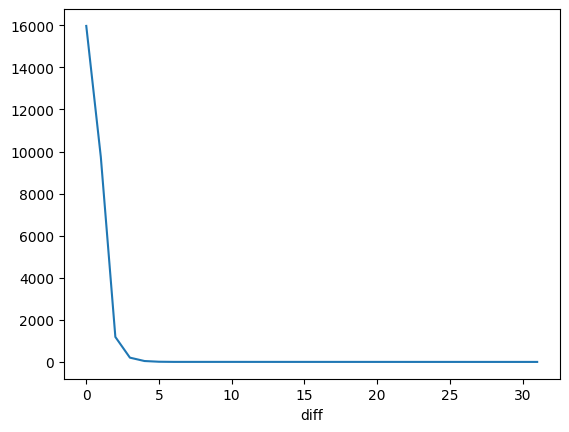

In [104]:
predictions['diff'].round().value_counts().sort_index().plot()